In [9]:
import numpy as np
import pylab
import itertools
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
plt.rcParams["figure.figsize"]=(12,9)

In [10]:
def twospirals(n_points, noise=.0, square=False, sine=False):
    '''
     Returns n_points for the two spirals dataset.
    '''
    n_points = int(n_points/2)
    n = np.sqrt( np.random.rand(n_points,1) ) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    d1 = (d1x, d1y)
    negd1 = (-d1x, -d1y)

    if sine: 
        sinx1, sinx2 = np.sin(d1x), np.sin(d1y)
        d1 += (sinx1, sinx2)
        negd1 += (-sinx1, -sinx2)
    if square:
        sqx1, sqx2 = d1x*d1x, d1y*d1y
        d1 += (sqx1, sqx2)
        negd1 += (-sqx1, -sqx2)

    x1 = np.hstack(d1)
    x2 = np.hstack(negd1)
    x = np.vstack( (x1, x2) )
    y = np.hstack( ( np.zeros(n_points), np.ones(n_points) ) )
    return (x, y.astype(int))

In [11]:
# X_train, y_train = twospirals(n_points=200)
# X_test, y_test = twospirals(n_points=200)

# plt.title('training and testing set')
# plt.plot(X_train[y_train==0,0], X_train[y_train==0,1], '.', label='training class 1')
# plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], '.', label='training class 2')
# plt.plot(X_test[y_test==0,0], X_test[y_test==0,1], '.', label='testing class 1')
# plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], '.', label='testing class 2')
# plt.legend()
# plt.show()

In [12]:
def fitness_func(population,X_train,y_train,X_test,y_test):
    fitness_list = np.zeros(N)
    mse_list = np.zeros(N)
    for member in range(len(population)):
        # TODO: add check for non zeros
        member_layer_sizes = tuple(int(l) for l in population[member])
        
        # fitness = test accuracy as %
        clf = MLPClassifier(max_iter=1, hidden_layer_sizes=member_layer_sizes, solver='lbfgs', random_state=0)
        clf.fit(X_train, y_train)
        fitness = clf.score(X_test, y_test) * 100

        # mse for test set just for plotting
        mse_list[member] = mean_squared_error(y_test, clf.predict(X_test))
        # sort population in descending fitness
        fitness_list[member] = fitness
        fitness_indices = (-fitness_list).argsort()
        sorted_pop = population[fitness_indices]

    mse = np.sum(mse_list)/N
    avg_fitness = np.sum(fitness_list)/N
    max_fitness = max(fitness_list)
    fitness_list = fitness_list[fitness_indices]
    return sorted_pop, fitness_list, avg_fitness, max_fitness, mse

In [13]:
def roulette_wheel_selection(sorted_pop, fitness_list):
    '''
    sorted_pop = population members sorted in descending (best to worst)
    fitness_list = corresponding fitness list for sorted_pop
    '''
    intermediate_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))
    total_fit = np.sum(fitness_list)
    select_from = np.arange(N)

    if total_fit == 0:
        total_fit = 1
        relative_fitness = fitness_list + 1/N
    else:
        relative_fitness = fitness_list / total_fit

    mating_population = np.random.choice(select_from, size=N, p=relative_fitness)
    for member in range(len(mating_population)):
        intermediate_pop[member] = sorted_pop[mating_population[member]]
    return intermediate_pop

In [14]:
def crossover(parent1, parent2,p_c):
  #  print(f"dim = {dim} and len = {len(parent1)}")
    if np.random.rand()<p_c:

        c_point = np.random.randint(0, dim) # random rossover point
        child1 = np.random.randint(low=1, high=neuron_range, size=dim)
        child2 = np.random.randint(low=1, high=neuron_range, size=dim)

        child1[:c_point] = parent1[:c_point]
        child1[c_point:] = parent2[c_point:]

        child2[c_point:] = parent1[c_point:]
        child2[:c_point] = parent2[:c_point]
        return child1, child2
    else:
        return parent1,parent2
        

In [15]:
def mutate(population,p_m):
    for member in population:
        for chromosome in range(dim):
            if np.random.rand()<p_m:
                # change a chromosome to random int (between 1-8)
                member[chromosome] = np.random.randint(1, dim)
    return population

In [16]:
def new_generation(intermediate_pop,p_c,p_m):
    new_pop = np.ones((N,dim))
    parent_list = np.arange(N)
    pairings = np.random.choice(parent_list, (2,int(N/2)), replace =False)
    #print(pairings)
    for x in range(np.int(N/2)):
        parent1 = pairings[0][x]
        parent2 = pairings[1][x]
        new_pop[x], new_pop[(N-1)-x] = crossover(intermediate_pop[parent1], intermediate_pop[parent2],p_c)
    mutate(new_pop,p_m)
    return new_pop

<br><br>
# TESTS

In [39]:

X_train, y_train = twospirals(n_points=200,square=True)
X_test, y_test = twospirals(n_points=200,square=True)

dim = 4            # number of layers i.e. dimension of the search space (D)
neuron_range = 9    # neurons on each hidden layer can range from 1 to 9
N = 10              # Size of the population of solutions
T = 100             # Number of generations
p_c = 0.7           # Crossover probability
p_m = 0.01         # Mutation probbability

init_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))
print(f'init_pop.shape {init_pop.shape}\ninit_pop = \n{init_pop[:10]}\n...')

init_pop.shape (10, 4)
init_pop = 
[[2 3 4 8]
 [1 1 3 5]
 [6 7 8 6]
 [1 6 1 1]
 [4 4 5 1]
 [7 1 5 3]
 [5 7 6 3]
 [6 6 5 5]
 [5 5 7 3]
 [7 7 3 7]]
...


In [27]:

# @ignore_warnings(category=ConvergenceWarning)
# def test_function():
#     cur_gen = init_pop
#     generation_avg_fitness = []
#     generation_max_fitness = []
#     generation_mse = []
#     for t in range(T):
#         sorted_pop, fitness_list, avg_fitness, max_fitness, mse = fitness_func(cur_gen)
#         generation_mse.append(mse)
#         generation_avg_fitness.append(avg_fitness)
#         generation_max_fitness.append(max_fitness)
#         intermediate_pop = roulette_wheel_selection(sorted_pop, fitness_list)
#         new_gen = new_generation(intermediate_pop)
#         cur_gen = new_gen
        
#       #  print(f"t={t} and avg_fitness = {avg_fitness} and [p[ {cur_gen}]]")
#      #   print(f"t = {t} and avg_fitness = {avg_fitness}  and pop = {cur_gen}")

#         #print(f"avg Fitness {avg_fitness} at t= {t}")
# #         if avg_fitness ==100:
# #             print(f"Found perfect solution at generation {t}")
# #             break # you may like to remove the break to see how the avarege fitness approach the maximal fitness

#     return generation_mse,generation_avg_fitness,generation_max_fitness,cur_gen
# #generation_mse,generation_avg_fitness,generation_max_fitness,cur_gen=test_function()


In [37]:

init_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))

@ignore_warnings(category=ConvergenceWarning)
def test_function(X_train,y_train,X_test,y_test,init_pop,p_c,p_m):
    cur_gen = init_pop
    generation_avg_fitness = []
    generation_max_fitness = []
    generation_mse = []
    for t in range(T):
        sorted_pop, fitness_list, avg_fitness, max_fitness, mse =fitness_func(cur_gen,X_train,y_train,X_test,y_test)
        generation_mse.append(mse)
        generation_avg_fitness.append(avg_fitness)
        generation_max_fitness.append(max_fitness)
        intermediate_pop = roulette_wheel_selection(sorted_pop, fitness_list)
        new_gen = new_generation(intermediate_pop,p_c,p_m)
        cur_gen = new_gen
        
      #  print(f"t={t} and avg_fitness = {avg_fitness} and [p[ {cur_gen}]]")
     #   print(f"t = {t} and avg_fitness = {avg_fitness}  and pop = {cur_gen}")

      #  print(f"avg Fitness {avg_fitness} with pop = {cur_gen[0]}   t={t}")
#        /
        
    return generation_avg_fitness,cur_gen[0]

In [38]:
def labels(square,sin):
    text = "Inputs: Linear"
    if square:
        text+= ", Square"
    if sin:
        text+= ", Sine"
    return text

In [35]:
#test run
p_c=0.7
p_m=0.01
X_train, y_train = twospirals(n_points=200,square=True,sine=True)
X_test, y_test = twospirals(n_points=200,square=True,sine=True)
generation_avg_fitness,cur_gen = test_function(X_train,y_train,X_test,y_test,init_pop,p_c,p_m)


In [40]:
#running for all combinations of input features
X_train, y_train = twospirals(n_points=200,square=True)
X_test, y_test = twospirals(n_points=200,square=True)
booleanArray = [False,True]

fitness = np.zeros((4,T))
counter = 0
texts = []
for i in range(len(booleanArray)):
    for j in range(len(booleanArray)):
        X_train,y_train = twospirals(n_points=200,square=booleanArray[i],sine=booleanArray[j])
        X_test,y_test = twospirals(n_points=200,square=booleanArray[i],sine=booleanArray[j])
        generation_avg_fitness,cur_gen = test_function(X_train,y_train,X_test,y_test,init_pop,p_c,p_m)
        fitness[counter]=generation_avg_fitness
        text = labels(booleanArray[i],booleanArray[j])
        texts.append(text)
        counter+=1
        print(f"{i},{j} = {cur_gen}")


0,0 = [7. 2. 1. 7.]
0,1 = [1. 6. 3. 3.]
1,0 = [3. 7. 8. 8.]
1,1 = [1. 1. 7. 5.]


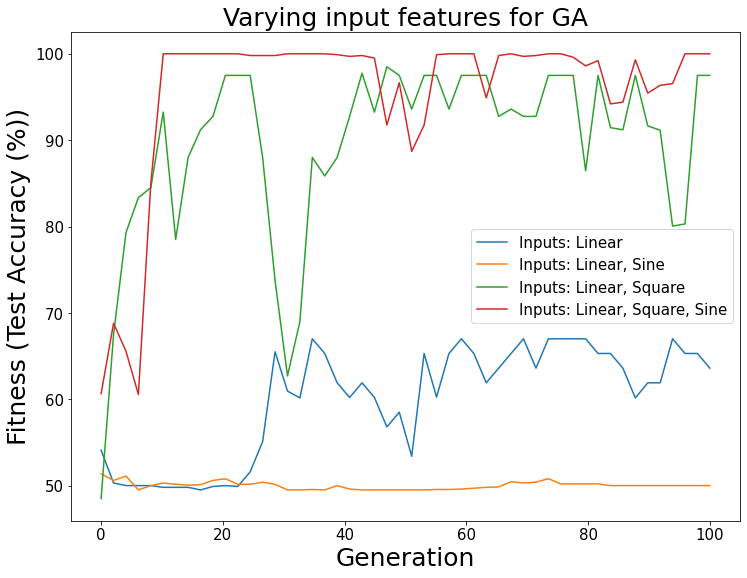

100


In [41]:
points = np.linspace(0,T,int(T/2))
for i in range(len(fitness)):
    plt.plot(points,fitness[i][::2], label=texts[i])
plt.legend(fontsize=15)
pylab.xlabel('Generation',fontsize=25)
pylab.ylabel('Fitness (Test Accuracy (%))',fontsize=25)
pylab.title("Varying input features for GA",fontsize=25)
pylab.savefig("figures/bestInput.png")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()
print(T)

In [42]:
#running for varying crossover and mutation probability
pcs = [0.7,0.05,0.99]
pms = [0.01,0.001,0.5]
T=1000
#default, low cross, high cross, low prob and high prob?
X_train, y_train = twospirals(n_points=200,square=True,sine=True)
X_test, y_test = twospirals(n_points=200,square=True,sine=True)

init_pop = np.random.randint(low=1, high=neuron_range, size=(N,dim))

fitness=[]
for i in range(len(pcs)):
    generation_avg_fitness,cur_gen1 = test_function(X_train,y_train,X_test,y_test,init_pop,pcs[i],pms[0])
    fitness.append(generation_avg_fitness)
    print("first ",i)

for j in range(1,len(pms)):
    generation_avg_fitness,cur_gen1 = test_function(X_train,y_train,X_test,y_test,init_pop,pcs[0],pms[i])
    fitness.append(generation_avg_fitness)
    print("second ",i)

first  0
first  1
first  2
second  2
second  2


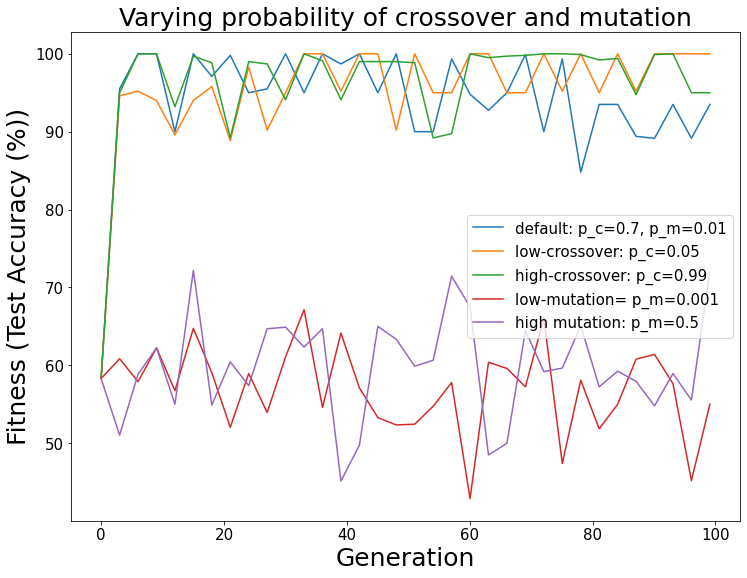

1000


In [47]:
texts = ["default: p_c=0.7, p_m=0.01","low-crossover: p_c=0.05","high-crossover: p_c=0.99"
         ,"low-mutation= p_m=0.001","high mutation: p_m=0.5"]
points = np.linspace(0,100,T)
for i in range(len(fitness)):
    plt.plot(points[::30],fitness[i][::30], label=texts[i])
plt.legend(loc=0,fontsize=15)
pylab.xlabel('Generation',fontsize=25)
pylab.ylabel('Fitness (Test Accuracy (%))',fontsize=25)
pylab.savefig("figures/bestInput.svg")
pylab.xticks(fontsize=15)
pylab.yticks(fontsize=15)
#plt.title(fontsize=25)
pylab.title("Varying probability of crossover and mutation",fontsize=25)
pylab.savefig("figures/parameters.png")

plt.show()
print(T)

max fitness achieved 99.0 @ gen 135


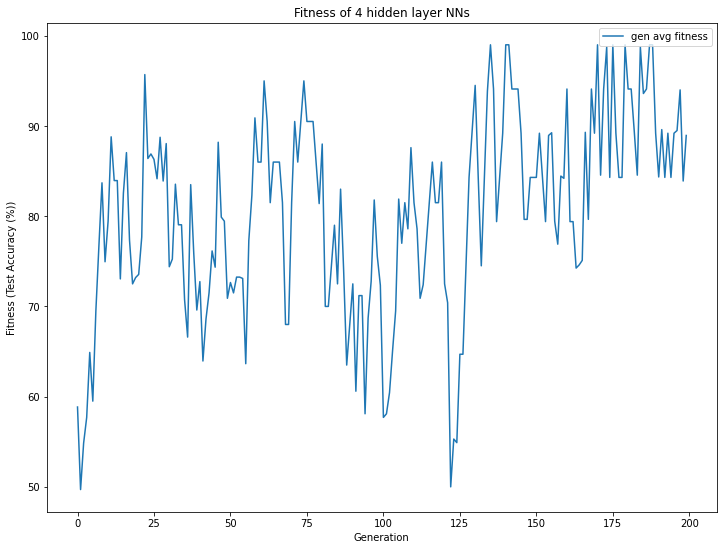

In [174]:
pylab.xlabel('Generation')
pylab.ylabel('Fitness (Test Accuracy (%))')
pylab.title(f'Fitness of {dim} hidden layer NNs')
pylab.plot(generation_avg_fitness[::], label='gen avg fitness');
#pylab.plot(generation_max_fitness[::], label='gen max fintess');
pylab.legend(loc='upper right')

avg = max(generation_avg_fitness)
print(f'max fitness achieved {avg} @ gen {generation_avg_fitness.index(avg)}')

min mse achieved 0.0050 @ gen 43 w/ pop 30


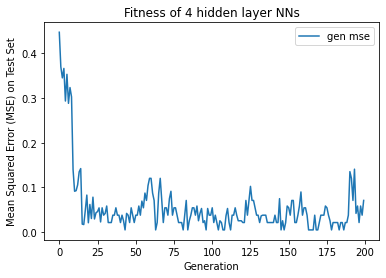

In [91]:
pylab.xlabel('Generation')
pylab.ylabel('Mean Squared Error (MSE) on Test Set')
pylab.title(f'Fitness of {dim} hidden layer NNs')
pylab.plot(generation_mse[::], label='gen mse');
pylab.legend(loc='upper right')

min_mse = min(generation_mse)
print(f'min mse achieved {min_mse:.4f} @ gen {generation_mse.index(min_mse)} w/ pop {N}')